1. Chargement et exploration des données

In [3]:
import pandas as pd
import numpy as np
import missingno as msno
import matplotlib.pyplot as plt
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import MissingIndicator, KNNImputer, SimpleImputer
from sklearn.impute import IterativeImputer
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix

In [4]:
# Charger les données
df = pd.read_csv(r"C:\Users\kadas\Desktop\Mes_cours\SCORING\hmeq.csv")

# Afficher les premières lignes pour une vue d'ensemble
df.head()

,BAD,LOAN,MORTDUE,VALUE,REASON,JOB,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
0,1,1100,25860.0,39025.0,HomeImp,Other,10.5,0.0,0.0,94.366667,1.0,9.0,NaN
1,1,1300,70053.0,68400.0,HomeImp,Other,7.0,0.0,2.0,121.833333,0.0,14.0,NaN
2,1,1500,13500.0,16700.0,HomeImp,Other,4.0,0.0,0.0,149.466667,1.0,10.0,NaN
3,1,1500,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,0,1700,97800.0,112000.0,HomeImp,Office,3.0,0.0,0.0,93.333333,0.0,14.0,NaN


2. Résumé des valeurs manquantes

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5442 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5708 non-null   object 
 5   JOB      5681 non-null   object 
 6   YOJ      5445 non-null   float64
 7   DEROG    5252 non-null   float64
 8   DELINQ   5380 non-null   float64
 9   CLAGE    5652 non-null   float64
 10  NINQ     5450 non-null   float64
 11  CLNO     5738 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [6]:
df["REASON"].unique()

array(['HomeImp', nan, 'DebtCon'], dtype=object)

In [7]:
df["JOB"].unique()

array(['Other', nan, 'Office', 'Sales', 'Mgr', 'ProfExe', 'Self'],
      dtype=object)

In [8]:
# Tableau des valeurs manquantes par colonne
missing_values = df.isnull().sum()
missing_percent = (missing_values / len(df)) * 100
missing_table = pd.DataFrame(
    {"Missing Values": missing_values, "Percentage": missing_percent}
)
print(missing_table)

         Missing Values  Percentage
BAD                   0    0.000000
LOAN                  0    0.000000
MORTDUE             518    8.691275
VALUE               112    1.879195
REASON              252    4.228188
JOB                 279    4.681208
YOJ                 515    8.640940
DEROG               708   11.879195
DELINQ              580    9.731544
CLAGE               308    5.167785
NINQ                510    8.557047
CLNO                222    3.724832
DEBTINC            1267   21.258389


In [9]:
cat_col = ["BAD", "REASON", "JOB"]
num_col = [
    "LOAN",
    "MORTDUE",
    "VALUE",
    "YOJ",
    "CLAGE",
    "CLNO",
    "DEBTINC",
    "DEROG",
    "NINQ",
    "DELINQ",
]

In [10]:
# msno.bar(df)
# plt.show()

* La carte thermique de corrélation des valeurs manquantes

Elle met en évidence les relations entre les valeurs manquantes des différentes variables.

In [11]:
# msno.heatmap(df)
# plt.show()

Nous sommes confronté à un cas de données manquantes MAR 

- DEROG et DELINQ (Corrélation forte : 0.8) :  Probablement MAR  car ces deux variables sont liées aux comportements de crédit des individus.

Il y a une forte corrélation des valeurs manquantes entre DEROG (nombre de rapports dérogatoires) et DELINQ (nombre de lignes de crédit en retard). Cela signifie que, lorsque les données sont manquantes pour DEROG, elles sont souvent manquantes pour DELINQ.

Stratégie d'imputation : Imputer ces deux variables ensemble à l'aide d'une méthode KNN, car elles sont liées et leur absence semble dépendante de facteurs communs.


In [12]:
# Imputation par KNN    flexible qui fonctionne bien pour l'imputation des valeurs manquantes MAR
imputer_knn = KNNImputer(n_neighbors=5)
df[["DEROG", "DELINQ"]] = imputer_knn.fit_transform(df[["DEROG", "DELINQ"]])

* CLNO, CLAGE, et NINQ (Corrélation modérée)

In [13]:
from sklearn.impute import KNNImputer

imputer_knn = KNNImputer(n_neighbors=5)
df[["CLNO", "CLAGE", "NINQ"]] = imputer_knn.fit_transform(df[["CLNO", "CLAGE", "NINQ"]])

* YOJ et MORTDUE (Corrélation faible)

L'imputation par la moyenne consiste à remplacer les valeurs manquantes par la moyenne des valeurs 
non manquantes dans la variable. Cette méthode est utile pour les variables continues et symétriques.

L'imputation par la médiane consiste à remplacer les valeurs manquantes par la médiane des valeurs non
manquantes dans la variable. Cette méthode est utile pour les variables continues qui ont une distribution
 asymétrique ou pour les variables ordinales.

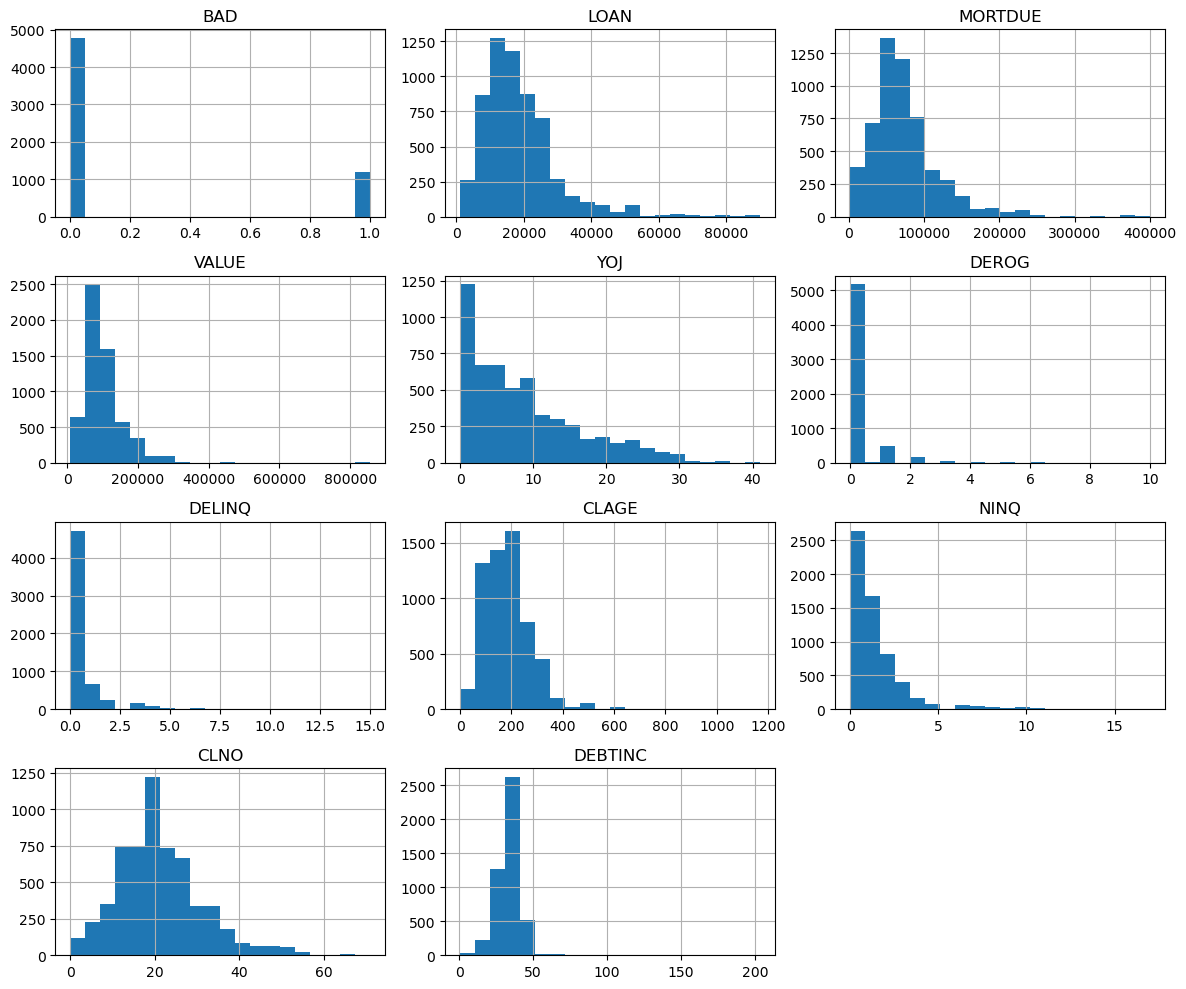

In [14]:
import pandas as pd
import matplotlib.pyplot as plt

# Afficher les histogrammes pour toutes les variables numériques
df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

In [15]:
df["YOJ"].fillna(df["YOJ"].median(), inplace=True)
df["MORTDUE"].fillna(df["MORTDUE"].median(), inplace=True)

* Imputation par le mode

In [16]:
df["REASON"].fillna(df["REASON"].mode()[0], inplace=True)
df["JOB"].fillna(df["JOB"].mode()[0], inplace=True)

In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5960 non-null   float64
 3   VALUE    5848 non-null   float64
 4   REASON   5960 non-null   object 
 5   JOB      5960 non-null   object 
 6   YOJ      5960 non-null   float64
 7   DEROG    5960 non-null   float64
 8   DELINQ   5960 non-null   float64
 9   CLAGE    5960 non-null   float64
 10  NINQ     5960 non-null   float64
 11  CLNO     5960 non-null   float64
 12  DEBTINC  4693 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


* DEBTINC (Corrélation faible avec les autres variables) et distr asymétrique 

car la médiane est moins influencée par les valeurs extrêmes que la moyenne.

Type de valeur manquante : MCAR ou MAR, car les informations sur la dette 
et le revenu peuvent être manquantes pour des raisons aléatoires (par exemple, informations non collectées).


In [18]:
df["DEBTINC"].fillna(df["DEBTINC"].median(), inplace=True)

In [19]:
df["VALUE"].fillna(df["VALUE"].median(), inplace=True)

# ANALYSE DESCRIPTIVE

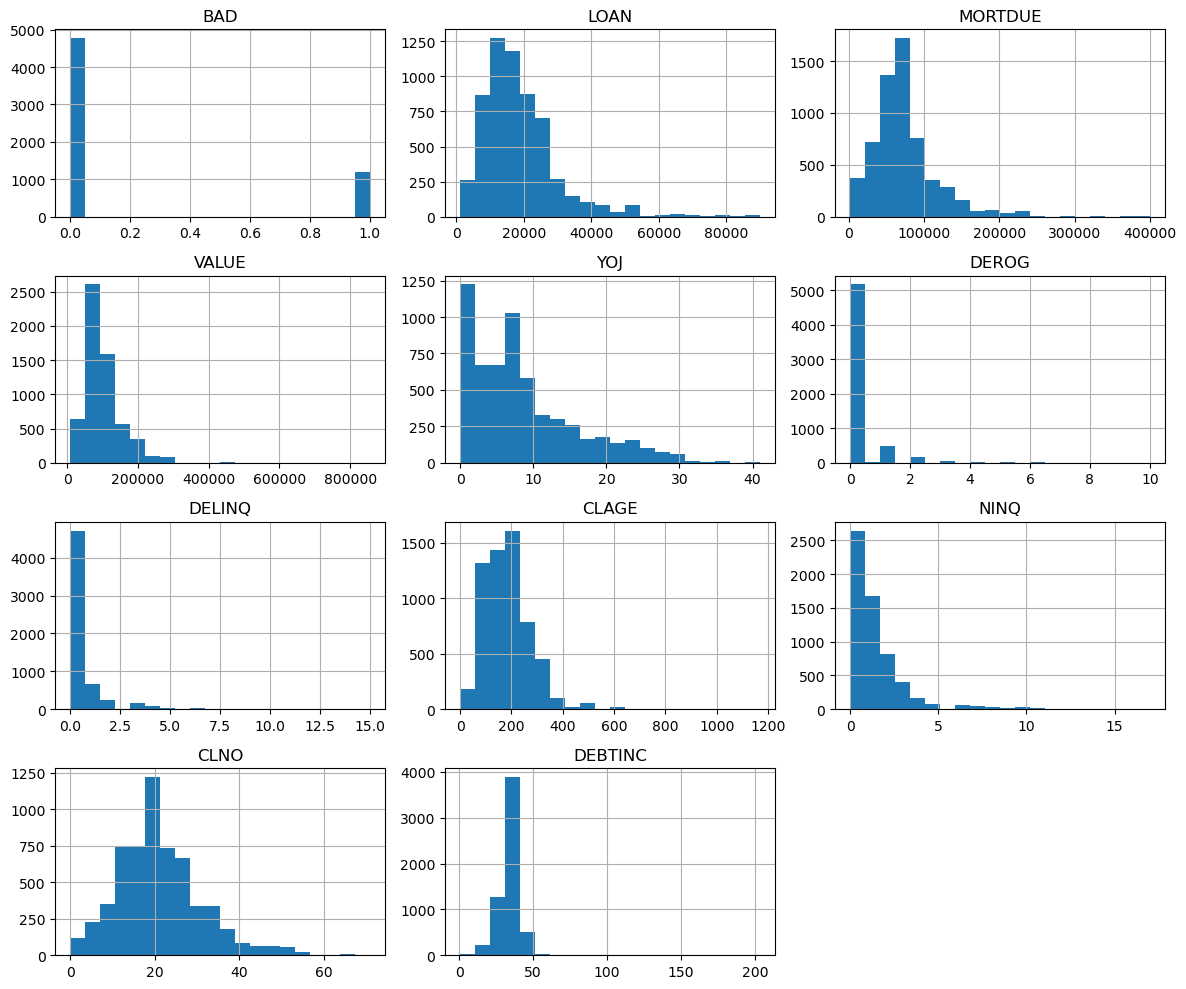

In [20]:
# Afficher les histogrammes pour toutes les variables numériques
df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

In [21]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5960 entries, 0 to 5959
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      5960 non-null   int64  
 1   LOAN     5960 non-null   int64  
 2   MORTDUE  5960 non-null   float64
 3   VALUE    5960 non-null   float64
 4   REASON   5960 non-null   object 
 5   JOB      5960 non-null   object 
 6   YOJ      5960 non-null   float64
 7   DEROG    5960 non-null   float64
 8   DELINQ   5960 non-null   float64
 9   CLAGE    5960 non-null   float64
 10  NINQ     5960 non-null   float64
 11  CLNO     5960 non-null   float64
 12  DEBTINC  5960 non-null   float64
dtypes: float64(9), int64(2), object(2)
memory usage: 605.4+ KB


In [22]:
# Statistiques descriptives pour les variables quantitatives
df.describe()

# # Histogrammes
# df.hist(figsize=(12, 10), bins=20)
# plt.tight_layout()
# plt.show()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC
count,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000,5960.000000
mean,0.199497,18607.969799,73001.041812,101540.387423,8.756166,0.261988,0.466354,181.301335,1.199011,21.296096,34.000651
std,0.399656,11207.480417,42552.726779,56869.436682,7.259424,0.800583,1.091602,87.628505,1.683046,9.948280,7.644528
min,0.000000,1100.000000,2063.000000,8000.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.524499
25%,0.000000,11100.000000,48139.000000,66489.500000,3.000000,0.000000,0.000000,116.722309,0.000000,15.000000,30.763159
50%,0.000000,16300.000000,65019.000000,89235.500000,7.000000,0.000000,0.000000,177.006893,1.000000,21.000000,34.818262
75%,0.000000,23300.000000,88200.250000,119004.750000,12.000000,0.000000,0.449442,229.449913,2.000000,26.000000,37.949892
max,1.000000,89900.000000,399550.000000,855909.000000,41.000000,10.000000,15.000000,1168.233561,17.000000,71.000000,203.312149


In [23]:
cat_col = ["BAD", "REASON", "JOB"]
num_col = [
    "LOAN",
    "MORTDUE",
    "VALUE",
    "YOJ",
    "CLAGE",
    "CLNO",
    "DEBTINC",
    "DEROG",
    "NINQ",
    "DELINQ",
]

In [24]:
# !pip install jupyter-black
# %load_ext jupyter_black
# Traitement des outliers

from scipy.stats.mstats import winsorize

# df_copy = df.copy()
# Appliquer la winsorisation à 5% des deux côtés (modifiez si nécessaire)
variables_to_winsor = ["LOAN", "MORTDUE", "VALUE", "CLAGE", "DEBTINC"]

# Appliquer la winsorisation sur chaque variable
for var in variables_to_winsor:
    df[var + "_winsor"] = winsorize(df[var], limits=[0.05, 0.05])  # 5% des deux côtés

# Afficher un aperçu des nouvelles variables winsorisées
df[
    [
        "LOAN",
        "LOAN_winsor",
        "MORTDUE",
        "MORTDUE_winsor",
        "VALUE",
        "VALUE_winsor",
        "CLAGE",
        "CLAGE_winsor",
        "DEBTINC",
        "DEBTINC_winsor",
    ]
].head()

,LOAN,LOAN_winsor,MORTDUE,MORTDUE_winsor,VALUE,VALUE_winsor,CLAGE,CLAGE_winsor,DEBTINC,DEBTINC_winsor
0,1100,5900,25860.0,25860.0,39025.0,39264.0,94.366667,94.366667,34.818262,34.818262
1,1300,5900,70053.0,70053.0,68400.0,68400.0,121.833333,121.833333,34.818262,34.818262
2,1500,5900,13500.0,19111.0,16700.0,39264.0,149.466667,149.466667,34.818262,34.818262
3,1500,5900,65019.0,65019.0,89235.5,89235.5,179.766275,179.766275,34.818262,34.818262
4,1700,5900,97800.0,97800.0,112000.0,112000.0,93.333333,93.333333,34.818262,34.818262


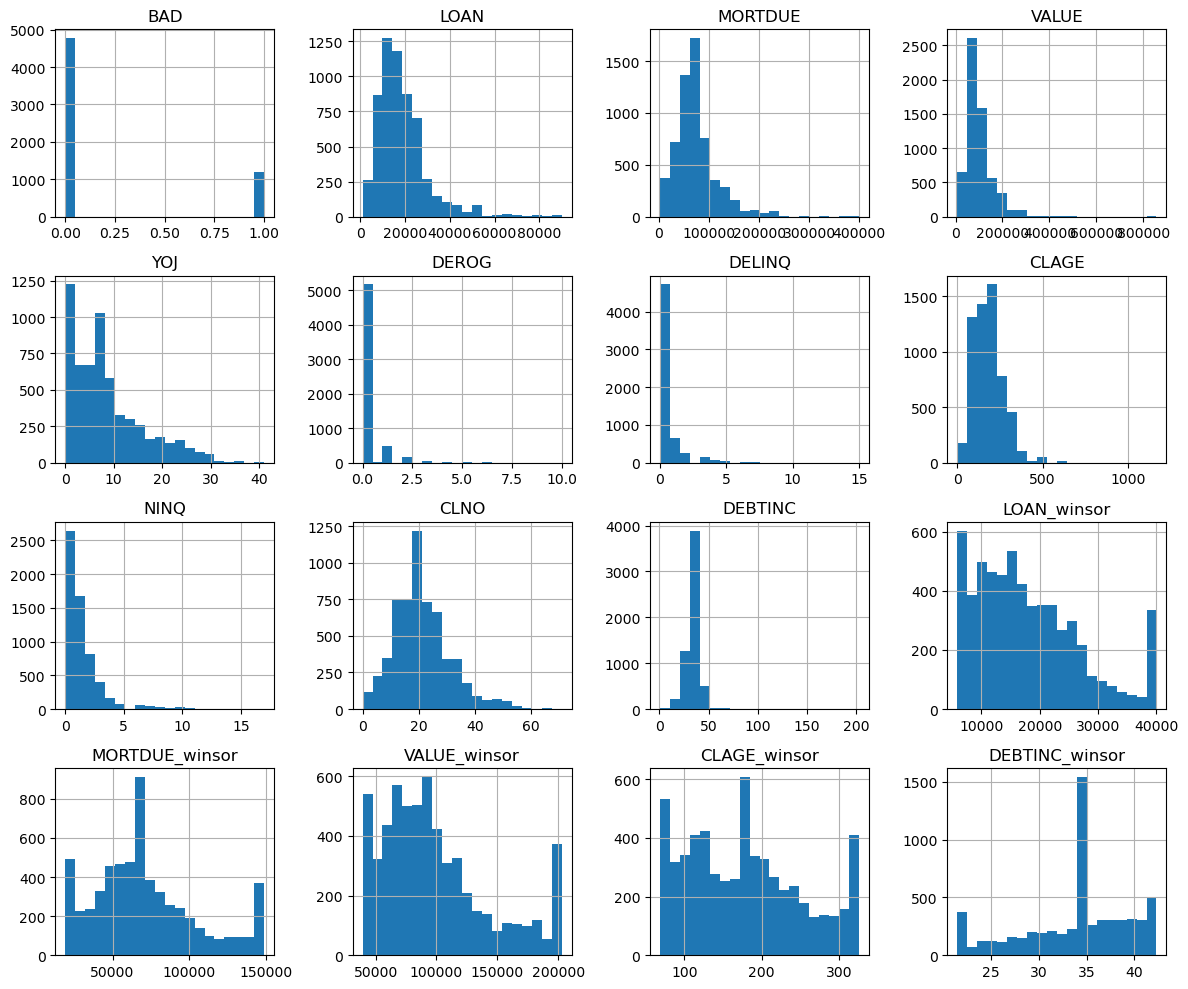

In [25]:
# Histogrammes
df.hist(figsize=(12, 10), bins=20)
plt.tight_layout()
plt.show()

* verification de  l'effet de la winsorisation

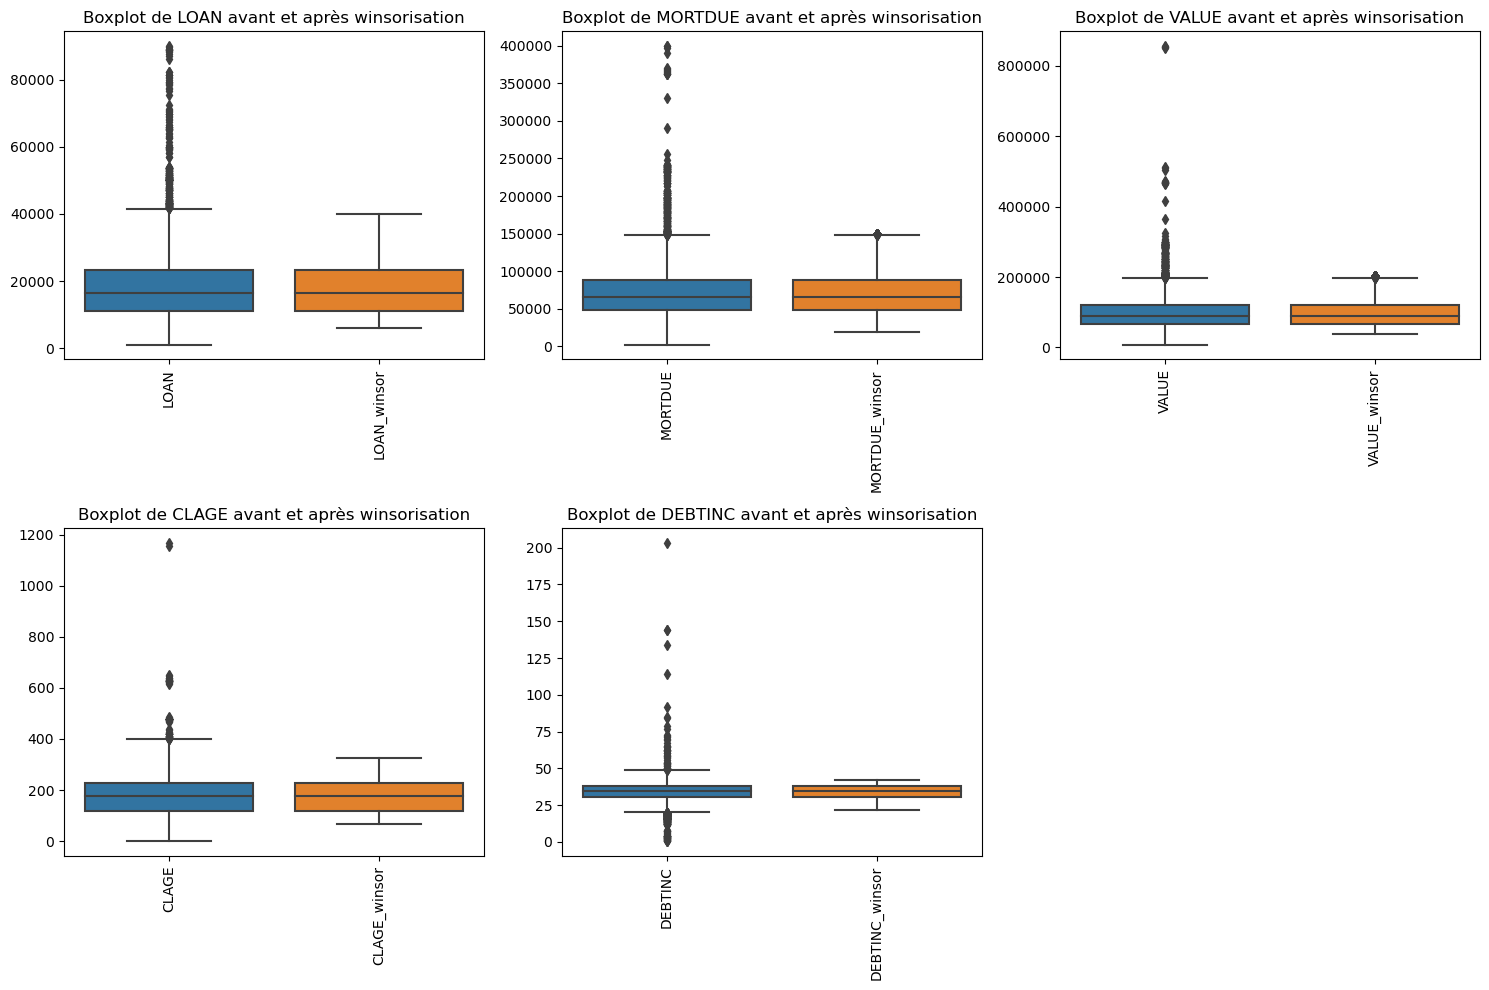

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables à comparer
variables_to_compare = ["LOAN", "MORTDUE", "VALUE", "CLAGE", "DEBTINC"]

# Créer des boxplots pour comparer avant et après winsorisation
plt.figure(figsize=(15, 10))
for i, var in enumerate(variables_to_compare, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(data=df[[var, var + "_winsor"]])
    plt.title(f"Boxplot de {var} avant et après winsorisation")
    plt.xticks(rotation=90)

plt.tight_layout()
plt.show()

* Encodage des variables catégorielles :

In [27]:
df = pd.get_dummies(df, columns=["REASON", "JOB"], drop_first=True)
df

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,...,MORTDUE_winsor,VALUE_winsor,CLAGE_winsor,DEBTINC_winsor,REASON_HomeImp,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1100,25860.0,39025.0,10.5,0.00000,0.000000,94.366667,1.000000,9.000000,...,25860.0,39264.0,94.366667,34.818262,True,False,True,False,False,False
1,1,1300,70053.0,68400.0,7.0,0.00000,2.000000,121.833333,0.000000,14.000000,...,70053.0,68400.0,121.833333,34.818262,True,False,True,False,False,False
2,1,1500,13500.0,16700.0,4.0,0.00000,0.000000,149.466667,1.000000,10.000000,...,19111.0,39264.0,149.466667,34.818262,True,False,True,False,False,False
3,1,1500,65019.0,89235.5,7.0,0.25457,0.449442,179.766275,1.186055,21.296096,...,65019.0,89235.5,179.766275,34.818262,False,False,True,False,False,False
4,0,1700,97800.0,112000.0,3.0,0.00000,0.000000,93.333333,0.000000,14.000000,...,97800.0,112000.0,93.333333,34.818262,True,True,False,False,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5955,0,88900,57264.0,90185.0,16.0,0.00000,0.000000,221.808718,0.000000,16.000000,...,57264.0,90185.0,221.808718,36.112347,False,False,True,False,False,False
5956,0,89000,54576.0,92937.0,16.0,0.00000,0.000000,208.692070,0.000000,15.000000,...,54576.0,92937.0,208.692070,35.859971,False,False,True,False,False,False
5957,0,89200,54045.0,92924.0,15.0,0.00000,0.000000,212.279697,0.000000,15.000000,...,54045.0,92924.0,212.279697,35.556590,False,False,True,False,False,False
5958,0,89800,50370.0,91861.0,14.0,0.00000,0.000000,213.892709,0.000000,16.000000,...,50370.0,91861.0,213.892709,34.340882,False,False,True,False,False,False


In [28]:
# Afficher un aperçu des nouvelles variables winsorisées
df[
    [
        "BAD",
        "LOAN_winsor",
        "MORTDUE_winsor",
        "VALUE_winsor",
        "CLAGE_winsor",
        "DEBTINC_winsor",
        "DEROG",
        "NINQ",
        "DELINQ",
    ]
].corr()

,BAD,LOAN_winsor,MORTDUE_winsor,VALUE_winsor,CLAGE_winsor,DEBTINC_winsor,DEROG,NINQ,DELINQ
BAD,1.000000,-0.080047,-0.062131,-0.065839,-0.157239,0.118898,0.264221,0.161676,0.334989
LOAN_winsor,-0.080047,1.000000,0.218949,0.344305,0.092699,0.089255,0.002449,0.049925,-0.023023
MORTDUE_winsor,-0.062131,0.218949,1.000000,0.834955,0.129330,0.156369,-0.041161,0.013953,-0.007558
VALUE_winsor,-0.065839,0.344305,0.834955,1.000000,0.174007,0.131261,-0.042470,0.004044,-0.019851
CLAGE_winsor,-0.157239,0.092699,0.129330,0.174007,1.000000,-0.019550,-0.086337,-0.131335,0.006553
DEBTINC_winsor,0.118898,0.089255,0.156369,0.131261,-0.019550,1.000000,0.014318,0.132001,0.026522
DEROG,0.264221,0.002449,-0.041161,-0.042470,-0.086337,0.014318,1.000000,0.151742,0.229193
NINQ,0.161676,0.049925,0.013953,0.004044,-0.131335,0.132001,0.151742,1.000000,0.058264
DELINQ,0.334989,-0.023023,-0.007558,-0.019851,0.006553,0.026522,0.229193,0.058264,1.000000


In [29]:
# df = [
#     "LOAN",
#     "MORTDUE",
#     "VALUE",
#     "YOJ",
#     "CLAGE",
#     "CLNO",
#     "DEBTINC",
#     "DEROG",
#     "NINQ",
#     "DELINQ",
# ]

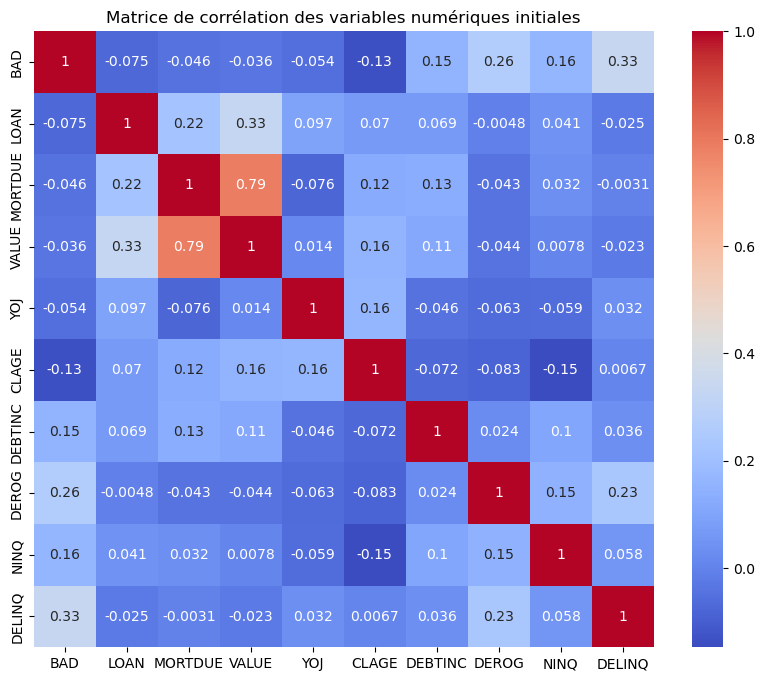

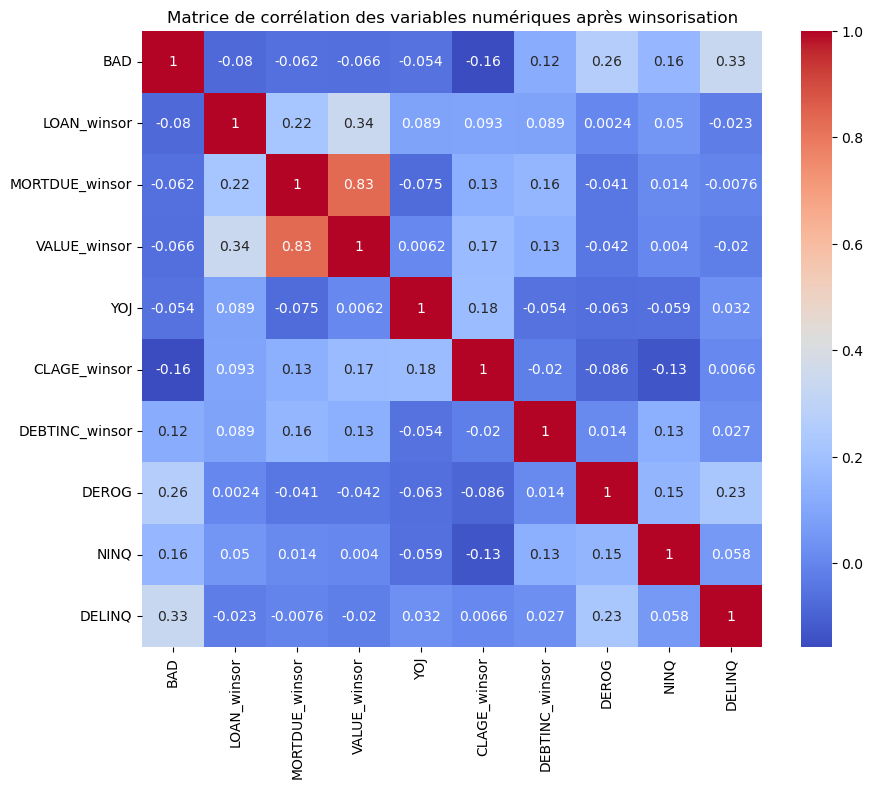

In [30]:
import seaborn as sns
import matplotlib.pyplot as plt

# Variables numériques initiales avant la winsorisation
num_vars_initial = [
    "BAD",
    "LOAN",
    "MORTDUE",
    "VALUE",
    "YOJ",
    "CLAGE",
    "DEBTINC",
    "DEROG",
    "NINQ",
    "DELINQ",
]

# Création de la heatmap des corrélations initiales
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_vars_initial].corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation des variables numériques initiales")
plt.show()

# Variables après winsorisation
num_vars_winsor = [
    "BAD",
    "LOAN_winsor",
    "MORTDUE_winsor",
    "VALUE_winsor",
    "YOJ",
    "CLAGE_winsor",
    "DEBTINC_winsor",
    "DEROG",
    "NINQ",
    "DELINQ",
]

# Création de la heatmap des corrélations après winsorisation
plt.figure(figsize=(10, 8))
sns.heatmap(df[num_vars_winsor].corr(), annot=True, cmap="coolwarm")
plt.title("Matrice de corrélation des variables numériques après winsorisation")
plt.show()

In [31]:
# Pas de value et mortdue
df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'LOAN_winsor', 'MORTDUE_winsor',
       'VALUE_winsor', 'CLAGE_winsor', 'DEBTINC_winsor', 'REASON_HomeImp',
       'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self'],
      dtype='object')

* Qualitatif vs Qualitatif

In [32]:
# from scipy.stats import chi2_contingency

# # Tableau croisé pour JOB et REASON
# contingency_table = pd.crosstab(df["BAD"], df["REASON"])
# print(contingency_table)

# # Test du chi² pour évaluer la dépendance
# chi2, p, dof, ex = chi2_contingency(contingency_table)
# print(f"Chi² : {chi2}, p-value : {p}")

* Analyse des Variables Catégorielles (Modalités)

In [33]:
# # Tableau croisé REASON et JOB (CSP)
# reason_job = pd.crosstab(df["REASON"], df["JOB"])
# print(reason_job)
# import seaborn as sns

# # Visualiser la répartition des montants de LOAN selon la REASON et la JOB (CSP)
# sns.catplot(x="REASON", y="LOAN", hue="JOB", kind="bar", data=df)
# plt.title("Montant du prêt par motif et par profession")
# plt.show()

In [34]:
df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'LOAN_winsor', 'MORTDUE_winsor',
       'VALUE_winsor', 'CLAGE_winsor', 'DEBTINC_winsor', 'REASON_HomeImp',
       'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self'],
      dtype='object')

In [35]:
# test futru ingeniering
# Interaction entre CLAGE et LOAN : L'ancienneté de la ligne de crédit (CLAGE) combinée au
# montant du prêt (LOAN) peut révéler des patterns intéressants.
# Interaction YOJ (années à l'emploi) et LOAN : Plus un client est stable dans son emploi (ancienneté plus longue),
# plus il pourrait être susceptible de rembourser son prêt.

In [36]:
df["LOAN_CLAGE_interaction"] = df["LOAN"] * df["CLAGE"]
df["LOAN_YOJ_interaction"] = df["LOAN"] * df["YOJ"]

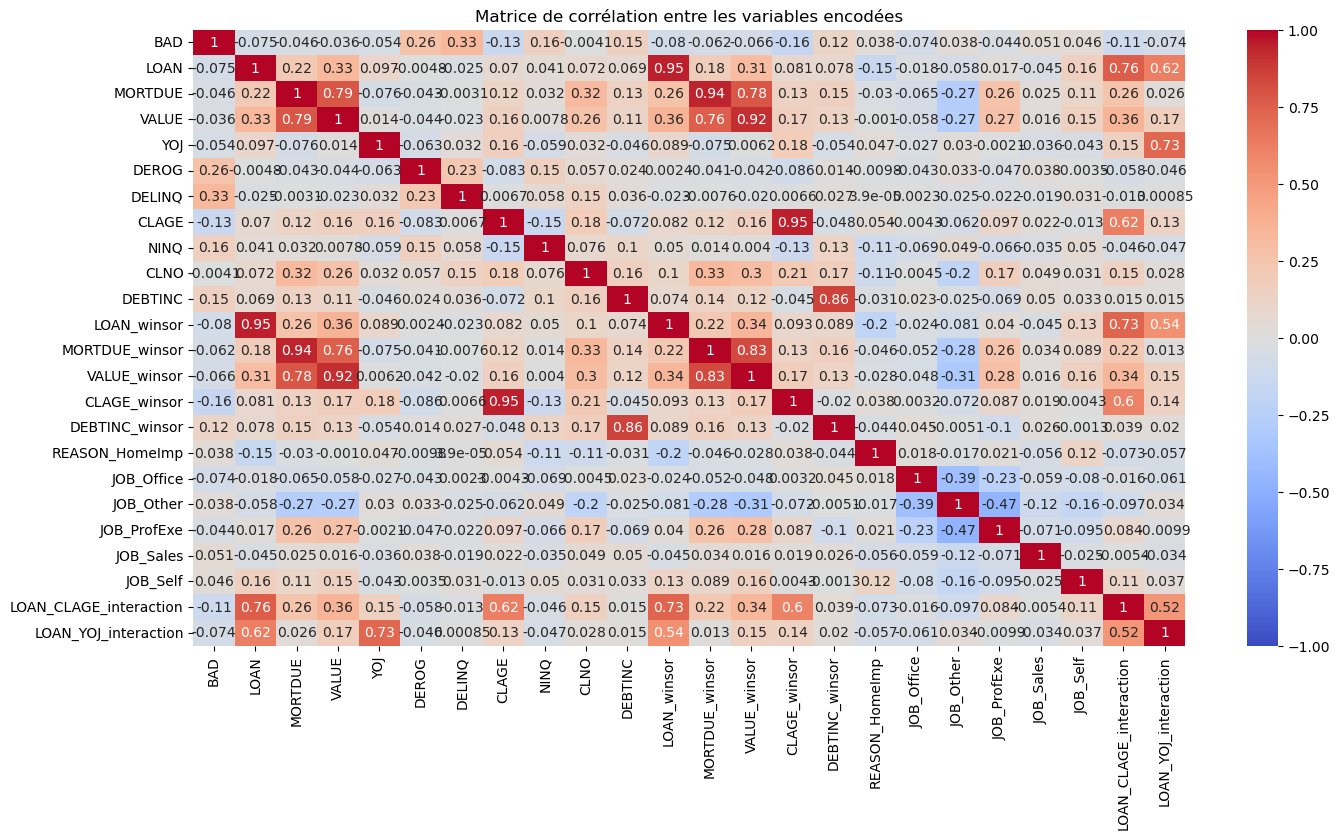

In [37]:
# Calculer la matrice de corrélation
corr_matrix = df.corr()

# Visualiser la matrice de corrélation
plt.figure(figsize=(16, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", vmin=-1, vmax=1)
plt.title("Matrice de corrélation entre les variables encodées")
plt.show()

In [38]:
# corréle avec BAD : DEROG ,DELINQ ,CLAGE(-) ,NINQ ,DEBTINC

# MORTDUE et VALUE , sont fortement corrélé

In [39]:
# test de model

In [40]:
from sklearn.model_selection import train_test_split

# Variables explicatives et cible
X = df.drop("BAD", axis=1)
y = df["BAD"]

# Séparation des données en train et test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42
)

In [41]:
df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'LOAN_winsor', 'MORTDUE_winsor',
       'VALUE_winsor', 'CLAGE_winsor', 'DEBTINC_winsor', 'REASON_HomeImp',
       'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self',
       'LOAN_CLAGE_interaction', 'LOAN_YOJ_interaction'],
      dtype='object')

In [42]:
# Modélisation 1

In [43]:
df_initial = df[
    [
        "BAD",
        "LOAN",
        "MORTDUE",
        "YOJ",
        "DEROG",
        "DELINQ",
        "CLAGE",
        "NINQ",
        "CLNO",
        "DEBTINC",
        "REASON_HomeImp",
        "JOB_Office",
        "JOB_Other",
        "JOB_ProfExe",
        "JOB_Sales",
        "JOB_Self",
    ]
]

In [44]:
# Diviser chaque dataframe en jeu d'entraînement et de test

In [45]:
from sklearn.model_selection import train_test_split

# Dataframe initial (remplacez par df_winsor ou df_mixed pour les autres cas)
X_initial = df_initial.drop("BAD", axis=1)
y_initial = df_initial["BAD"]

# Séparation en train et test
X_train_initial, X_test_initial, y_train_initial, y_test_initial = train_test_split(
    X_initial, y_initial, test_size=0.3, random_state=42
)

In [46]:
# modèle de régression logistique

In [47]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Modèle de régression logistique pour le dataframe initial
model_initial = LogisticRegression(max_iter=1000)
model_initial.fit(X_train_initial, y_train_initial)

# Prédictions
y_pred_initial = model_initial.predict(X_test_initial)

# Évaluation du modèle
print("Évaluation pour le dataframe initial :")
print(classification_report(y_test_initial, y_pred_initial))
print(f"AUC : {roc_auc_score(y_test_initial, y_pred_initial)}")

Évaluation pour le dataframe initial :
              precision    recall  f1-score   support

           0       0.78      1.00      0.88      1389
           1       0.78      0.02      0.03       399

    accuracy                           0.78      1788
   macro avg       0.78      0.51      0.45      1788
weighted avg       0.78      0.78      0.69      1788

AUC : 0.5080519874199537


In [48]:
df_winsor = df[
    [
        "BAD",
        "LOAN_winsor",
        "MORTDUE_winsor",
        "CLAGE_winsor",
        "DEBTINC_winsor",
        "YOJ",
        "DEROG",
        "DELINQ",
        "NINQ",
        "CLNO",
        "REASON_HomeImp",
        "JOB_Office",
        "JOB_Other",
        "JOB_ProfExe",
        "JOB_Sales",
        "JOB_Self",
    ]
]

In [49]:
# Dataframe initial (remplacez par df_winsor ou df_mixed pour les autres cas)
X_winsor = df_winsor.drop("BAD", axis=1)
y_winsor = df_winsor["BAD"]

# Séparation en train et test
X_train_winsor, X_test_winsor, y_train_winsor, y_test_winsor = train_test_split(
    X_winsor, y_winsor, test_size=0.3, random_state=42
)

In [50]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Modèle de régression logistique pour le dataframe initial
model_winsor = LogisticRegression(max_iter=1000)
model_winsor.fit(X_train_winsor, y_train_winsor)

# Prédictions
y_pred_winsor = model_winsor.predict(X_test_winsor)

# Évaluation du modèle
print("Évaluation pour le dataframe initial :")
print(classification_report(y_test_winsor, y_pred_winsor))
print(f"AUC : {roc_auc_score(y_test_winsor, y_pred_winsor)}")

Évaluation pour le dataframe initial :
              precision    recall  f1-score   support

           0       0.81      0.97      0.88      1389
           1       0.67      0.21      0.32       399

    accuracy                           0.80      1788
   macro avg       0.74      0.59      0.60      1788
weighted avg       0.78      0.80      0.76      1788

AUC : 0.5913975002300568


In [51]:
df_mixed = df[
    [
        "BAD",
        "LOAN_winsor",
        "MORTDUE_winsor",
        "CLAGE_winsor",
        "DEBTINC_winsor",
        "YOJ",
        "DEROG",
        "DELINQ",
        "NINQ",
        "CLNO",
        "REASON_HomeImp",
        "JOB_Office",
        "JOB_Other",
        "JOB_ProfExe",
        "JOB_Sales",
        "JOB_Self",
        "LOAN_CLAGE_interaction",
        "LOAN_YOJ_interaction",
    ]
]

In [52]:
# Dataframe initial (remplacez par df_winsor ou df_mixed pour les autres cas)
X_mixed = df_mixed.drop("BAD", axis=1)
y_mixed = df_mixed["BAD"]

# Séparation en train et test
X_train_mixed, X_test_mixed, y_train_mixed, y_test_mixed = train_test_split(
    X_mixed, y_mixed, test_size=0.3, random_state=42
)

In [53]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, roc_auc_score

# Modèle de régression logistique pour le dataframe initial
model_mixed = LogisticRegression(max_iter=1000)
model_mixed.fit(X_train_mixed, y_train_mixed)

# Prédictions
y_pred_mixed = model_mixed.predict(X_test_mixed)

# Évaluation du modèle
print("Évaluation pour le dataframe initial :")
print(classification_report(y_test_mixed, y_pred_mixed))
print(f"AUC : {roc_auc_score(y_test_winsor, y_pred_mixed)}")

Évaluation pour le dataframe initial :
              precision    recall  f1-score   support

           0       0.78      1.00      0.87      1389
           1       0.00      0.00      0.00       399

    accuracy                           0.78      1788
   macro avg       0.39      0.50      0.44      1788
weighted avg       0.60      0.78      0.68      1788

AUC : 0.5


c:\Users\kadas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kadas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
c:\Users\kadas\anaconda3\Lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [54]:
print("Modèle basé sur les variables initiales :")
print(f"AUC : {roc_auc_score(y_test_initial, y_pred_initial)}")

print("Modèle basé sur les variables winsorisées :")
# AUC pour les variables winsorisées
print(f"AUC : {roc_auc_score(y_test_winsor, y_pred_winsor)}")

print("Modèle basé sur le dataframe mixte :")
# AUC pour le dataframe mixte
print(f"AUC : {roc_auc_score(y_test_mixed, y_pred_mixed)}")

Modèle basé sur les variables initiales :
AUC : 0.5080519874199537
Modèle basé sur les variables winsorisées :
AUC : 0.5913975002300568
Modèle basé sur le dataframe mixte :
AUC : 0.5


# SM

In [55]:
df.columns

Index(['BAD', 'LOAN', 'MORTDUE', 'VALUE', 'YOJ', 'DEROG', 'DELINQ', 'CLAGE',
       'NINQ', 'CLNO', 'DEBTINC', 'LOAN_winsor', 'MORTDUE_winsor',
       'VALUE_winsor', 'CLAGE_winsor', 'DEBTINC_winsor', 'REASON_HomeImp',
       'JOB_Office', 'JOB_Other', 'JOB_ProfExe', 'JOB_Sales', 'JOB_Self',
       'LOAN_CLAGE_interaction', 'LOAN_YOJ_interaction'],
      dtype='object')

In [56]:
# Conversion des colonnes booléennes en int
df["REASON_HomeImp"] = df["REASON_HomeImp"].astype(int)
df["JOB_Office"] = df["JOB_Office"].astype(int)
df["JOB_Other"] = df["JOB_Other"].astype(int)
df["JOB_ProfExe"] = df["JOB_ProfExe"].astype(int)
df["JOB_Sales"] = df["JOB_Sales"].astype(int)
df["JOB_Self"] = df["JOB_Self"].astype(int)

In [57]:
df_initial = df[
    [
        "BAD",
        "LOAN",
        "DEROG",
        "DELINQ",
        "CLAGE",
        "NINQ",
        "CLNO",
        "DEBTINC",
        "REASON_HomeImp",
        "JOB_Office",
        "JOB_Sales",
        "JOB_Self",
    ]
]

In [58]:
#'MORTDUE', 'JOB_Other', 'JOB_ProfExe']

In [59]:
# 1. Séparation des variables explicatives (X) et de la variable cible (y)
X_initial = df_initial.drop("BAD", axis=1)  # Retirer la cible de X
y_initial = df_initial["BAD"]  # Extraire la cible

# 2. Séparation des données en train et test (70% train, 30% test)
X_train, X_test, y_train, y_test = train_test_split(
    X_initial, y_initial, test_size=0.3, random_state=42
)

# 3. Ajouter une constante pour l'intercept dans le jeu d'entraînement
X_train_const = sm.add_constant(X_train)
X_test_const = sm.add_constant(X_test)

# 4. Ajuster le modèle sur le jeu d'entraînement
model_initial = sm.Logit(y_train, X_train_const)
result_initial = model_initial.fit()

Optimization terminated successfully.
         Current function value: 0.388855
         Iterations 7


In [60]:
# 5. Résumé du modèle
print(result_initial.summary())

                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 4172
Model:                          Logit   Df Residuals:                     4160
Method:                           MLE   Df Model:                           11
Date:                Mon, 07 Oct 2024   Pseudo R-squ.:                  0.1987
Time:                        10:04:31   Log-Likelihood:                -1622.3
converged:                       True   LL-Null:                       -2024.6
Covariance Type:            nonrobust   LLR p-value:                1.896e-165
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.3919      0.294    -11.552      0.000      -3.967      -2.816
LOAN           -1.825e-05   4.61e-06     -3.961      0.000   -2.73e-05   -9.22e-06
DEROG              0.5487      0.055

DEROG, DELINQ, NINQ, DEBTINC : 

Des coefficients positifs indiquent que des antécédents de défaut de paiement, des lignes de crédit délinquantes ou des ratios d'endettement plus élevés augmentent la probabilité de défaut.

In [61]:
# 6. Prédictions sur le jeu d'entraînement et le jeu de test (probabilités)
y_train_pred_prob = result_initial.predict(
    X_train_const
)  # Probabilités sur le jeu d'entraînement
y_test_pred_prob = result_initial.predict(
    X_test_const
)  # Probabilités sur le jeu de test

In [62]:
# 7. Prédictions en classes (0 ou 1) pour le jeu d'entraînement
y_train_pred_class = (y_train_pred_prob > 0.5).astype(int)

# 8. Prédictions en classes (0 ou 1) pour le jeu de test
y_test_pred_class = (y_test_pred_prob > 0.5).astype(int)

In [63]:
# Part des observations bien et mal classées

# 9. Rapport de classification pour le jeu d'entraînement
print("Rapport de classification - Train :")
print(classification_report(y_train, y_train_pred_class))

# 10. Rapport de classification pour le jeu de test
print("\nRapport de classification - Test :")
print(classification_report(y_test, y_test_pred_class))

Rapport de classification - Train :
              precision    recall  f1-score   support

           0       0.85      0.97      0.91      3382
           1       0.69      0.27      0.39       790

    accuracy                           0.84      4172
   macro avg       0.77      0.62      0.65      4172
weighted avg       0.82      0.84      0.81      4172


Rapport de classification - Test :
              precision    recall  f1-score   support

           0       0.83      0.97      0.89      1389
           1       0.72      0.30      0.43       399

    accuracy                           0.82      1788
   macro avg       0.77      0.63      0.66      1788
weighted avg       0.80      0.82      0.79      1788



rappel très élevé (97% sur train, 97% sur test), ce qui signifie que le modèle capture bien les non-défaillants.

La précision est également très bonne (85% sur train, 83% sur test), ce qui signifie que la majorité des observations prédites comme non-défaillants sont effectivement correctes.

Classe 0 (non-défaillants) :

Le modèle est très performant pour identifier les non-défaillants (classe 0), avec un rappel très élevé (97% sur train, 97% sur test), ce qui signifie que le modèle capture bien les non-défaillants.
La précision est également très bonne (85% sur train, 83% sur test), ce qui signifie que la majorité des observations prédites comme non-défaillants sont effectivement correctes.



Classe 1 (défaillants) :

Le modèle a des difficultés à capturer les vrais défaillants. Le rappel pour la classe 1 est faible (27% sur train, 30% sur test), ce qui signifie que beaucoup de défaillants ne sont pas détectés (faux négatifs).
Cependant, la précision pour la classe 1 est correcte (69% sur train, 72% sur test), ce qui signifie que lorsqu'un client est prédit comme défaillant, le modèle est assez souvent correct.
Le F1-score est également relativement faible pour la classe 1 (39% sur train, 43% sur test), indiquant un équilibre limité entre la précision et le rappel pour cette classe.

In [64]:
# 11. Calcul de l'AUC pour le train et le test
auc_train = roc_auc_score(y_train, y_train_pred_prob)
auc_test = roc_auc_score(y_test, y_test_pred_prob)
print(f"AUC (Train) : {auc_train}")
print(f"AUC (Test) : {auc_test}")

# 12. Courbe ROC pour le jeu d'entraînement
fpr_train, tpr_train, thresholds_train = roc_curve(y_train, y_train_pred_prob)

# 13. Courbe ROC pour le jeu de test
fpr_test, tpr_test, thresholds_test = roc_curve(y_test, y_test_pred_prob)

AUC (Train) : 0.7913653070237819
AUC (Test) : 0.780893017280422


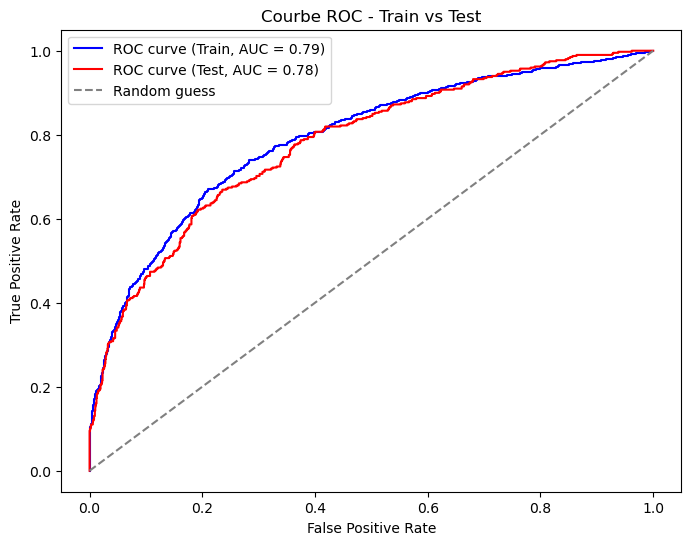

In [65]:
# 14. Tracer les courbes ROC sur le même graphique
plt.figure(figsize=(8, 6))

# Courbe ROC pour le jeu d'entraînement
plt.plot(
    fpr_train,
    tpr_train,
    label=f"ROC curve (Train, AUC = {auc_train:.2f})",
    color="blue",
)

# Courbe ROC pour le jeu de test
plt.plot(
    fpr_test, tpr_test, label=f"ROC curve (Test, AUC = {auc_test:.2f})", color="red"
)

# Ajouter la ligne aléatoire
plt.plot([0, 1], [0, 1], linestyle="--", color="gray", label="Random guess")

plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Courbe ROC - Train vs Test")
plt.legend()
plt.show()

# ma grille de score

In [66]:
# # Fonction pour convertir une probabilité en score sur une échelle de 0 à 100
# def probability_to_score_0_100(prob):
#     return (1 - prob) * 100


# # Exemple avec les probabilités prédites sur l'ensemble de test
# y_pred_prob_test = result_initial.predict(X_test_const)

# # Conversion des probabilités en scores sur l'échelle de 0 à 100
# X_test["score"] = probability_to_score_0_100(y_pred_prob_test)

In [67]:
# Afficher quelques scores
X_test.head(10)

,LOAN,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_HomeImp,JOB_Office,JOB_Sales,JOB_Self
1344,10600,0.0,0.0,170.340974,0.0,20.0,37.792555,0,1,0,0
625,7800,0.0,0.0,231.001195,0.0,32.0,35.906116,0,0,0,0
5908,65100,0.0,1.0,116.906104,0.0,11.0,43.368718,1,1,0,0
2991,16400,0.0,0.0,298.146552,0.0,20.0,29.153372,1,0,0,0
1545,11300,0.0,0.0,190.031218,0.0,15.0,39.008673,1,1,0,0
1860,12400,0.0,0.0,147.012827,6.0,29.0,39.930947,0,0,0,0
4129,21600,1.0,4.0,313.427322,2.0,18.0,37.971355,0,0,0,0
1643,11700,0.0,0.0,214.869817,2.0,15.0,40.287411,0,0,0,0
1374,10700,0.0,1.0,192.596855,0.0,12.0,28.828649,1,0,0,0
5919,68000,0.0,0.0,218.100000,3.0,25.0,34.818262,0,0,0,1


In [68]:
"Mgr",

('Mgr',)

In [69]:
print(result_initial.summary())

                           Logit Regression Results                           
Dep. Variable:                    BAD   No. Observations:                 4172
Model:                          Logit   Df Residuals:                     4160
Method:                           MLE   Df Model:                           11
Date:                Mon, 07 Oct 2024   Pseudo R-squ.:                  0.1987
Time:                        10:04:31   Log-Likelihood:                -1622.3
converged:                       True   LL-Null:                       -2024.6
Covariance Type:            nonrobust   LLR p-value:                1.896e-165
                     coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------
const             -3.3919      0.294    -11.552      0.000      -3.967      -2.816
LOAN           -1.825e-05   4.61e-06     -3.961      0.000   -2.73e-05   -9.22e-06
DEROG              0.5487      0.055

In [70]:
import pandas as pd

# Les coefficients obtenus du modèle logit
coefficients = {
    "const": -3.3919,
    "LOAN": -1.825e-05,
    "DEROG": 0.5487,
    "DELINQ": 0.6582,
    "CLAGE": -0.0030,
    "NINQ": 0.1707,
    "CLNO": -0.0209,
    "DEBTINC": 0.0685,
    "REASON_HomeImp": 0.2748,  # Catégorie REASON_DebtCon est la référence (coefficient nul)
    "JOB_Office": -0.6782,  # Catégorie JOB_Mgr est la référence (coefficient nul)
    "JOB_Sales": 1.2785,
    "JOB_Self": 0.4351,
}

# 1. Somme des coefficients positifs
sum_coeffs = sum([abs(coef) for coef in coefficients.values()])

# 2. Fixer une note maximale (exemple : 100)
max_score = 100

# 3. Calculer la grille de score en normalisant les coefficients sur 0 à 100
grille_score = {}
for variable, coef in coefficients.items():
    score = (coef / sum_coeffs) * max_score
    grille_score[variable] = score

# Afficher la grille de score
df_grille_score = pd.DataFrame(grille_score.items(), columns=["Variable", "Score"])
print(df_grille_score)

          Variable      Score
0            const -45.054018
1             LOAN  -0.000242
2            DEROG   7.288287
3           DELINQ   8.742756
4            CLAGE  -0.039848
5             NINQ   2.267378
6             CLNO  -0.277611
7          DEBTINC   0.909874
8   REASON_HomeImp   3.650121
9       JOB_Office  -9.008413
10       JOB_Sales  16.982093
11        JOB_Self   5.779358


In [71]:
# Assure-toi que les variables dans la grille de score correspondent bien aux colonnes du DataFrame df

# Calculer le score pour tous les clients
df["score"] = df.apply(
    lambda x: grille_score["const"]
    + sum(x[var] * grille_score[var] for var in grille_score if var != "const"),
    axis=1,
)

# Optionnel : normaliser sur une échelle de 0 à 100
min_score = df["score"].min()
max_score = df["score"].max()

df["normalized_score"] = 100 * (df["score"] - min_score) / (max_score - min_score)

# Afficher les scores normalisés
print(df[["score", "normalized_score"]].head())

       score  normalized_score
0 -13.981823         24.880035
1  -1.294731         30.886290
2 -16.552049         23.663252
3 -18.338886         22.817337
4 -26.749939         18.835421


In [72]:
df[["BAD", "CLAGE", "score", "normalized_score"]]

,BAD,CLAGE,score,normalized_score
0,1,94.366667,-13.981823,24.880035
1,1,121.833333,-1.294731,30.886290
2,1,149.466667,-16.552049,23.663252
3,1,179.766275,-18.338886,22.817337
4,0,93.333333,-26.749939,18.835421
...,...,...,...,...
5955,0,221.808718,-47.027254,9.235841
5956,0,208.692070,-46.480836,9.494524
5957,0,212.279697,-46.948317,9.273211
5958,0,213.892709,-48.541792,8.518837


In [73]:
print(df)

      BAD   LOAN  MORTDUE     VALUE   YOJ    DEROG    DELINQ       CLAGE  \
0       1   1100  25860.0   39025.0  10.5  0.00000  0.000000   94.366667   
1       1   1300  70053.0   68400.0   7.0  0.00000  2.000000  121.833333   
2       1   1500  13500.0   16700.0   4.0  0.00000  0.000000  149.466667   
3       1   1500  65019.0   89235.5   7.0  0.25457  0.449442  179.766275   
4       0   1700  97800.0  112000.0   3.0  0.00000  0.000000   93.333333   
...   ...    ...      ...       ...   ...      ...       ...         ...   
5955    0  88900  57264.0   90185.0  16.0  0.00000  0.000000  221.808718   
5956    0  89000  54576.0   92937.0  16.0  0.00000  0.000000  208.692070   
5957    0  89200  54045.0   92924.0  15.0  0.00000  0.000000  212.279697   
5958    0  89800  50370.0   91861.0  14.0  0.00000  0.000000  213.892709   
5959    0  89900  48811.0   88934.0  15.0  0.00000  0.000000  219.601002   

          NINQ       CLNO  ...  REASON_HomeImp  JOB_Office  JOB_Other  \
0     1.000000